In [16]:
import yfinance as yf
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
stocks = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'NFLX']

[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 16115.828697851053 is not greater than 16115.883921186294. Delta is -0.05522333524095302


Regime
1   -0.000714
2    0.000802
0    0.022142
Name: Return, dtype: float64


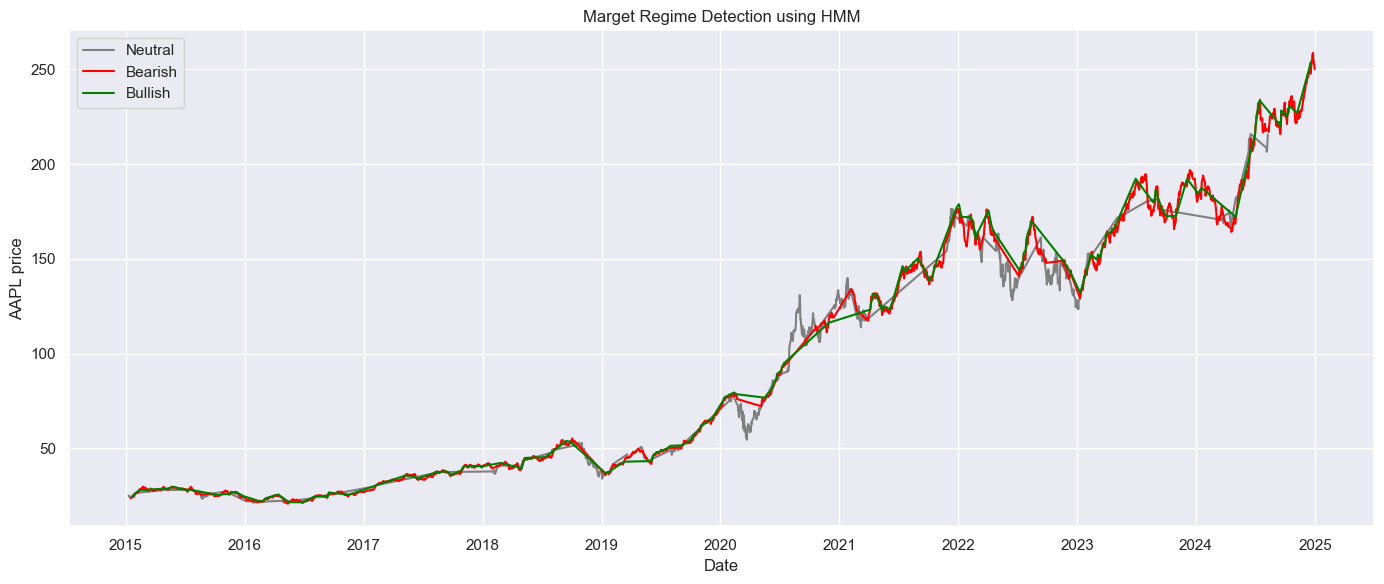

[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 16833.83168202316 is not greater than 16834.89615007015. Delta is -1.0644680469922605


Regime
2   -0.000088
0    0.000349
1    0.001738
Name: Return, dtype: float64


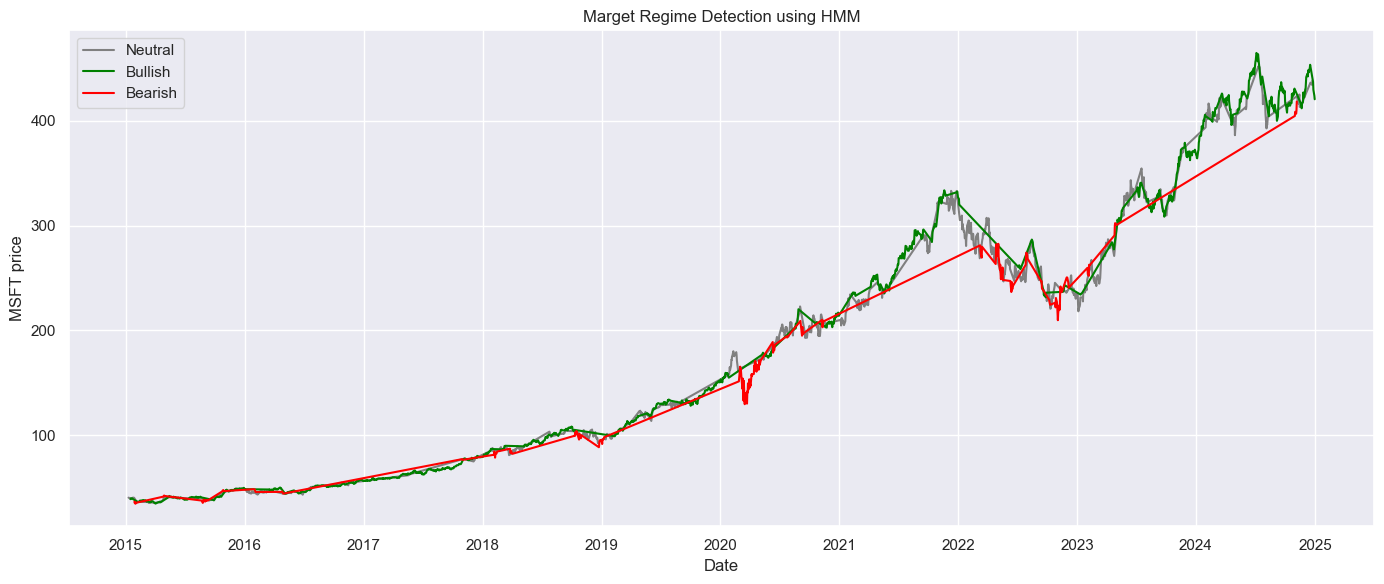

[*********************100%***********************]  1 of 1 completed


Regime
0   -0.007006
2    0.001265
1    0.012383
Name: Return, dtype: float64


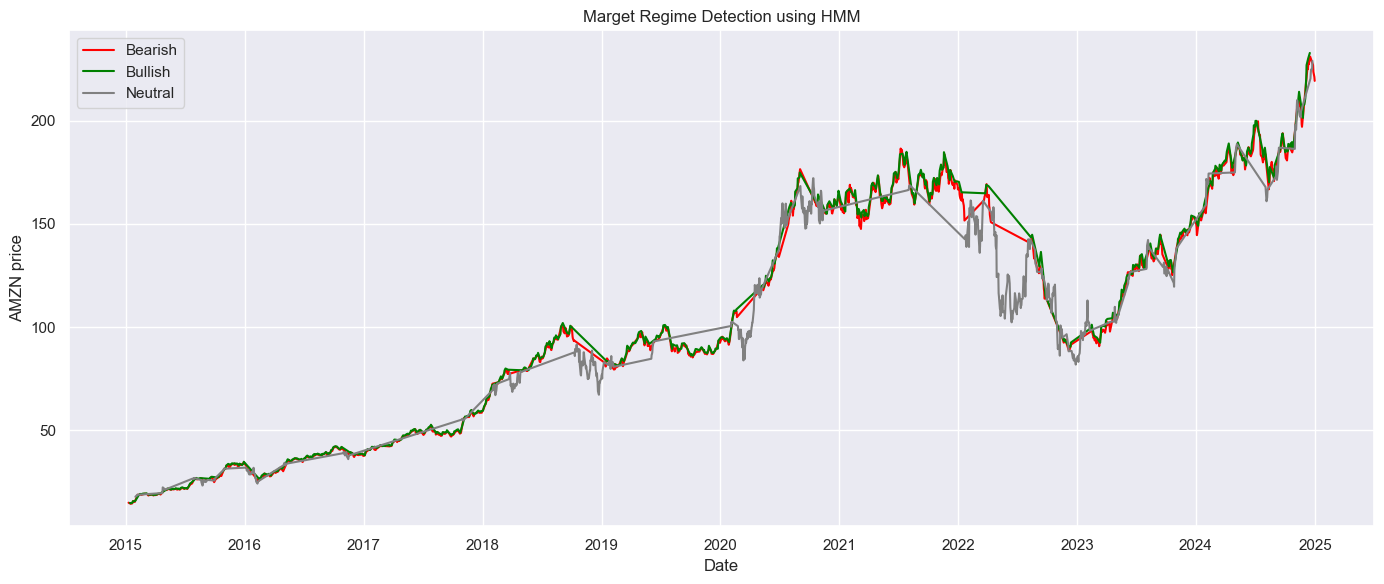

[*********************100%***********************]  1 of 1 completed
Model is not converging.  Current: 16619.715651145012 is not greater than 16619.959846128615. Delta is -0.244194983602938


Regime
2   -0.000655
0    0.000106
1    0.001954
Name: Return, dtype: float64


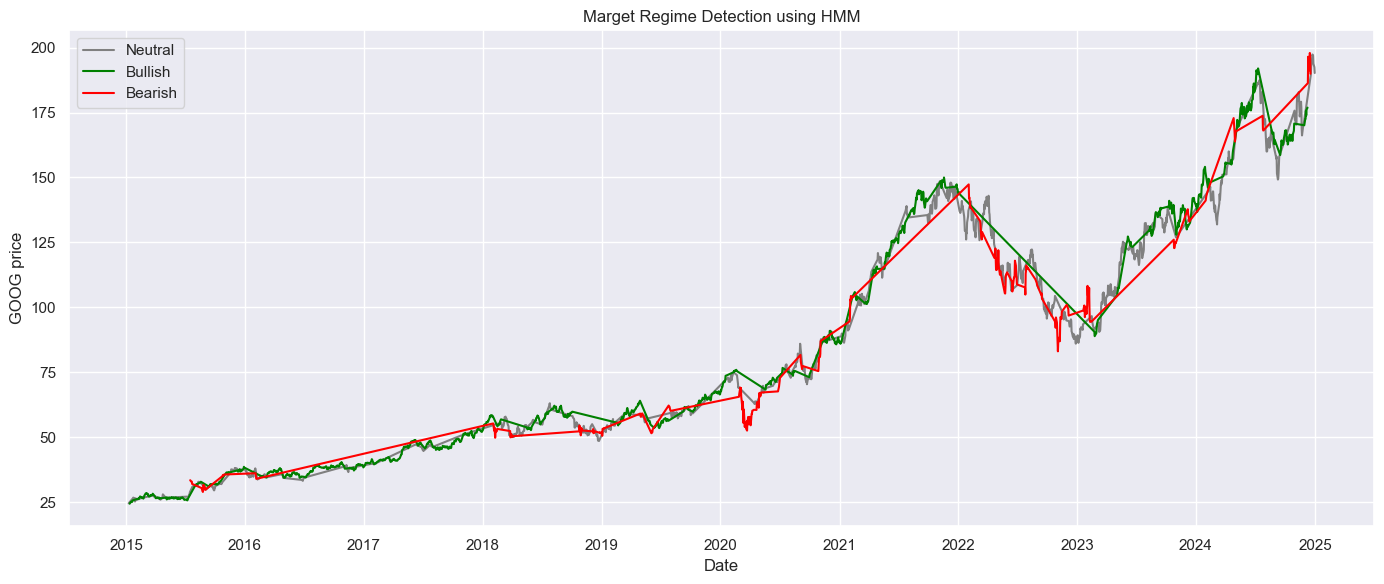

[*********************100%***********************]  1 of 1 completed


Regime
1    0.001341
2    0.001371
0    0.003731
Name: Return, dtype: float64


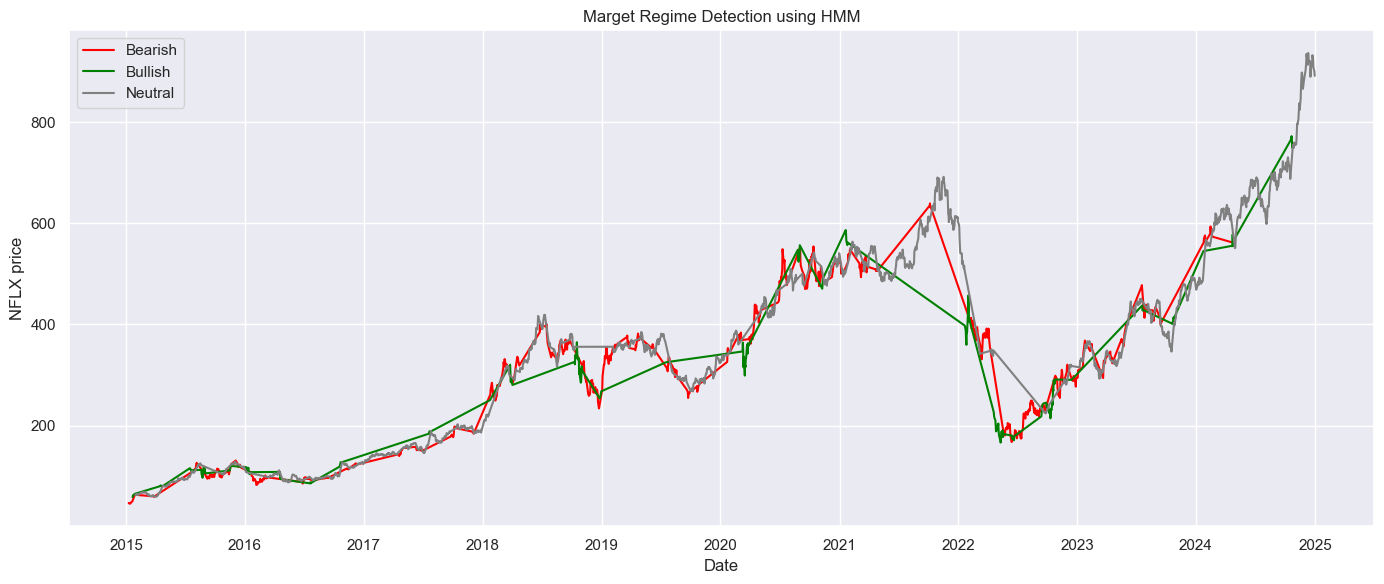

In [18]:
hmm_results = []

for stock in stocks:
    data = yf.download(stock, start="2015-01-01", end="2025-01-01")

    data = data[['Close']]
    data.rename(columns={'Close': 'price'}, inplace=True)

    data['Return'] = data['price'].pct_change().dropna()

    data['Volatility'] = data['Return'].rolling(window=5).std()
    data.dropna(inplace=True)

    features = data[['Return', 'Volatility']].values

    model = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(features)

    hidden_states = model.predict(features)
    data['Regime'] = hidden_states

    mean_returns = data.groupby('Regime')['Return'].mean().sort_values()
    print(mean_returns)
    regime_map = {mean_returns.index[0]: 'Bearish', mean_returns.index[1]: 'Neutral', mean_returns.index[2]: 'Bullish'}
    data['Market Regime'] = data['Regime'].map(regime_map)

    sns.set_theme(style="darkgrid")

    plt.figure(figsize=(14, 6))
    colors = {'Bullish': 'green', 'Neutral': 'gray', 'Bearish': 'red'}

    for regime in data["Market Regime"].unique():
        state_data = data[data["Market Regime"] == regime]
        plt.plot(state_data.index, state_data["price"], label=regime, color=colors[regime])

    plt.legend()
    plt.title("Marget Regime Detection using HMM")
    plt.xlabel("Date")
    plt.ylabel(f'{stock} price')
    plt.tight_layout()
    plt.show()

    df = data.copy()
    df_columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df.columns]
    df = df[['Return', 'Market Regime']].copy()
    df['stock'] = stock
    df = df.reset_index()

    hmm_results.append(df)



In [19]:
hmm_data = pd.concat(hmm_results)

pivot_returns = hmm_data.pivot_table(index='Date', columns='stock', values='Return')
pivot_regime = hmm_data.pivot_table(index='Date', columns='stock', values='Market Regime', aggfunc='first')

pivot_returns = pivot_returns.fillna(method='ffill').fillna(method='bfill')
pivot_regime = pivot_regime.fillna(method='ffill').fillna(method='bfill')

C:\Users\ROG\AppData\Local\Temp\ipykernel_28424\1733663063.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot_returns = hmm_data.pivot_table(index='Date', columns='stock', values='Return')
C:\Users\ROG\AppData\Local\Temp\ipykernel_28424\1733663063.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot_regime = hmm_data.pivot_table(index='Date', columns='stock', values='Market Regime', aggfunc='first')
C:\Users\ROG\AppData\Local\Temp\ipykernel_28424\1733663063.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pivot_returns = pivot_returns.fillna(method='ffill').fillna(method='bfill')
C:\Users\ROG\AppData\Local\Temp\ipykernel_28424\1733663063.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill

In [20]:
pivot_regime.to_csv('./data/pivot_regime.csv', index=True)
pivot_returns.to_csv('./data/pivot_returns.csv', index=True)